In [1]:
import gym
import gym_oscillator
from gym import error, spaces, utils
from gym import Space
from gym.utils import seeding
from gym_oscillator.envs.osc_env import oscillatorEnv

from stable_baselines.common import set_global_seeds
from stable_baselines.common.policies import MlpPolicy, MlpLstmPolicy
from stable_baselines.common.vec_env import DummyVecEnv,SubprocVecEnv,VecNormalize, VecEnv
from stable_baselines import PPO2, ACKTR
import numpy as np
from gym.spaces import Box
import os
import numpy as np
import oscillator_cpp
import yaml
from collections import deque
import matplotlib.pyplot as plt
from tqdm import tqdm

/home/v_skliarova/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/v_skliarova/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/v_skliarova/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/v_skliarova/.local/lib/python3.7/site-packages/tensorflow/python/frame

In [2]:
from tools.tools import show_statistics, plot_statistics, collect_elites, set_model_env, show_box_plot, convert_to_period

In [3]:
model, env = set_model_env('configs/config.yml', pretrain=False)

Box(0.0, 6.2831854820251465, (1,), float32)




Instructions for updating:
Use keras.layers.flatten instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [4]:
env.action_space

Box(-1.0, 1.0, (2,), float32)

In [5]:
normal_vec = collect_elites(model, env, value=0.97,num_samples=10)

100%|██████████| 10/10 [00:01<00:00,  6.00it/s]


In [6]:
normal_vec

[[array([[0.26703537]], dtype=float32),
  -0.9616276383399963,
  array([0.9196167, 0.725498 ], dtype=float32)],
 [array([[0.53407073]], dtype=float32),
  -0.9378055191040039,
  array([0.9384185 , 0.27443022], dtype=float32)],
 [array([[0.7225663]], dtype=float32),
  -0.9684400391578675,
  array([0.85214067, 0.26242962], dtype=float32)],
 [array([[0.7696902]], dtype=float32),
  -0.9506944847106934,
  array([0.8901576, 0.5585936], dtype=float32)],
 [array([[0.95818573]], dtype=float32),
  -0.8647598838806152,
  array([0.992556  , 0.95678097], dtype=float32)],
 [array([[1.0524335]], dtype=float32),
  -0.8773673629760742,
  array([ 0.9716196 , -0.85921663], dtype=float32)],
 [array([[1.0681415]], dtype=float32),
  -0.863364315032959,
  array([0.98853505, 0.12775224], dtype=float32)],
 [array([[1.0838494]], dtype=float32),
  -0.9613686394691467,
  array([0.8286095, 0.7899383], dtype=float32)],
 [array([[1.1466813]], dtype=float32),
  -0.9108055114746094,
  array([0.91866106, 0.9396377 ], dt

In [17]:
high_a= [5000, 2]
low_a = [0, 1]
    
def denormalize_actions(action, high_a, low_a, i):
#         print('denorm', action)
    de_act = low_a[i] + (high_a[i]-low_a[i]) * (action+1)/2 
#         print('result', de_act)
    return int(de_act)

In [18]:
N = len(normal_vec)
obs_cool = np.array([normal_vec[i][0] for i in range(len(normal_vec))]).reshape(N,)
rews_cool = np.array([normal_vec[i][1] for i in range(len(normal_vec))]).reshape(N,)
good_acs = np.array([normal_vec[i][2] for i in range(len(normal_vec))]).reshape(N,2)  
    
ps = []
ws = []
ks = []
for i in good_acs:
    p = np.array(500)
    w = denormalize_actions(np.array(i[0]),high_a, low_a, 0) 
    k = denormalize_actions(np.array(i[1]),high_a, low_a, 1) 
    ps.append(p)
    ws.append(w)
    ks.append(k)
ps = np.array(ps).copy()
ws = np.array(ws).copy()
ks = np.array(ks).copy()

theta = [2 * np.pi/400*100*i for i in range(1, 5, 1)]

idx0 = np.where((obs_cool > 0) & (obs_cool <= theta[0]))
idx1 = np.where((obs_cool > theta[0]) & (obs_cool <= theta[1]))
idx2 = np.where((obs_cool > theta[1]) & (obs_cool <= theta[2]))
idx3 = np.where(obs_cool > theta[2])
interval=0
idx = [idx0, idx1, idx2, idx3]
int_idx = idx[0]
print('Statistics for theta interval {}.'.format(interval))
#     if rews_cool[int_idx].shape[0]>0:
print('Number of samples', rews_cool[int_idx].shape[0])
print('Mean reward is {} +- {}'.format(np.mean(rews_cool[int_idx]), np.std(rews_cool[int_idx])))
print('Mean width_p is {} +- {}'.format(int(np.mean(ps[int_idx])), int(np.std(ps[int_idx]))))
print('Mean gap is {} +- {}'.format(int(np.mean(ws[int_idx])), int(np.std(ws[int_idx]))))
print('Mean Kfactor is {} +- {}'.format(np.mean(ks[int_idx]), np.std(ks[int_idx])))

Statistics for theta interval 0.
Number of samples 79
Mean reward is -0.9234671396545217 +- 0.03237610933475614
Mean width_p is 500 +- 0
Mean gap is 4781 +- 144
Mean Kfactor is 1.0 +- 0.0


In [19]:
np.argmax(rews_cool[int_idx])

41

In [20]:
ps[int_idx][41], ws[int_idx][41], ks[int_idx][41]

(500, 4988, 1)

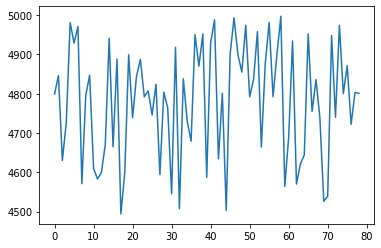

In [23]:
plt.plot(ws[int_idx])

In [7]:
ps, ws, ks, rs = show_statistics(0, normal_vec, model, True)

AttributeError: 'Box' object has no attribute 'denormalize'

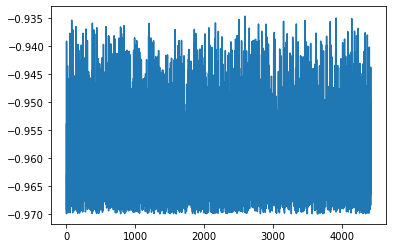

In [6]:
plt.plot(rs)

(array([3.957e+03, 0.000e+00, 3.300e+02, 0.000e+00, 0.000e+00, 1.140e+02,
        0.000e+00, 2.200e+01, 0.000e+00, 2.000e+00]),
 array([5. , 5.4, 5.8, 6.2, 6.6, 7. , 7.4, 7.8, 8.2, 8.6, 9. ]),
 <BarContainer object of 10 artists>)

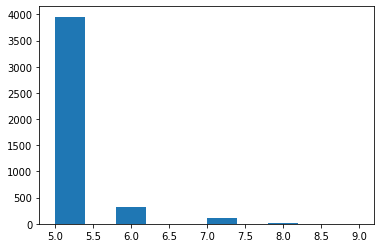

In [10]:
plt.hist(ks)

In [11]:
from tools.tools import convert_to_period

In [31]:
6280/15

418.6666666666667

In [25]:
ps[560]

89

In [26]:
convert_to_period(314)

0.04997465213085514

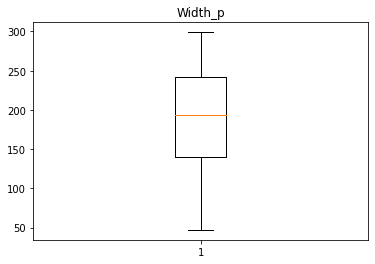

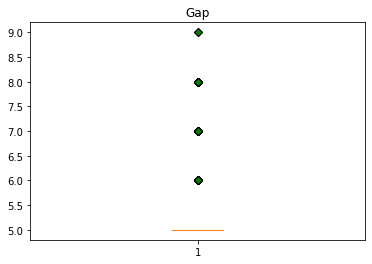

In [9]:
show_box_plot(ps, 'Width_p')
show_box_plot(ks, 'Gap')